In [ ]:
import wget
from zipfile import ZipFile

##Se descarga el archivo del repositorio 
file = wget.download("http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip")

##Se abre el archivo y se descomprime
zpFile = ZipFile(file)
zpFile.extractall()
zpFile.close()

In [2]:
import pandas as pd
import numpy as np
import math

dataset = pd.read_csv("msd_genre_dataset.txt", skiprows = range(9))

dataset.dropna()
dataset.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,...,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames Sarat,-8.697,155.007,1,9,1,246.33424,...,1255.514569,580.030472,598.485223,575.337671,322.068603,321.726029,232.700609,186.805303,181.938688,151.508011
1,classic pop and rock,TRNJTPB128F427AE9F,Blue Oyster Cult,Screams,-10.659,148.462,1,4,0,189.80526,...,2007.653070,1043.474073,585.694981,564.013736,510.177022,400.200186,365.119588,238.099708,197.933757,251.577525
2,classic pop and rock,TRLFJHA128F427AEEA,Blue Oyster Cult,Dance The Night Away,-13.494,112.909,1,10,0,158.19710,...,1204.856777,2736.520024,730.233239,665.203452,535.775111,439.335059,486.822970,265.333860,447.097987,251.880724
3,classic pop and rock,TRCQZAG128F427DB97,Blue Oyster Cult,Debbie Denise,-12.786,117.429,4,7,1,250.22649,...,809.755802,563.908070,492.803819,378.382799,372.875044,231.941957,246.313305,168.400152,85.282462,339.897173
4,classic pop and rock,TRNXMNM128F427DB8C,Blue Oyster Cult,(Don't Fear) The Reaper,-14.093,141.536,4,9,0,307.06893,...,1093.684935,343.556047,889.163314,218.111796,304.862864,178.352161,440.478867,142.669283,81.061326,208.355152


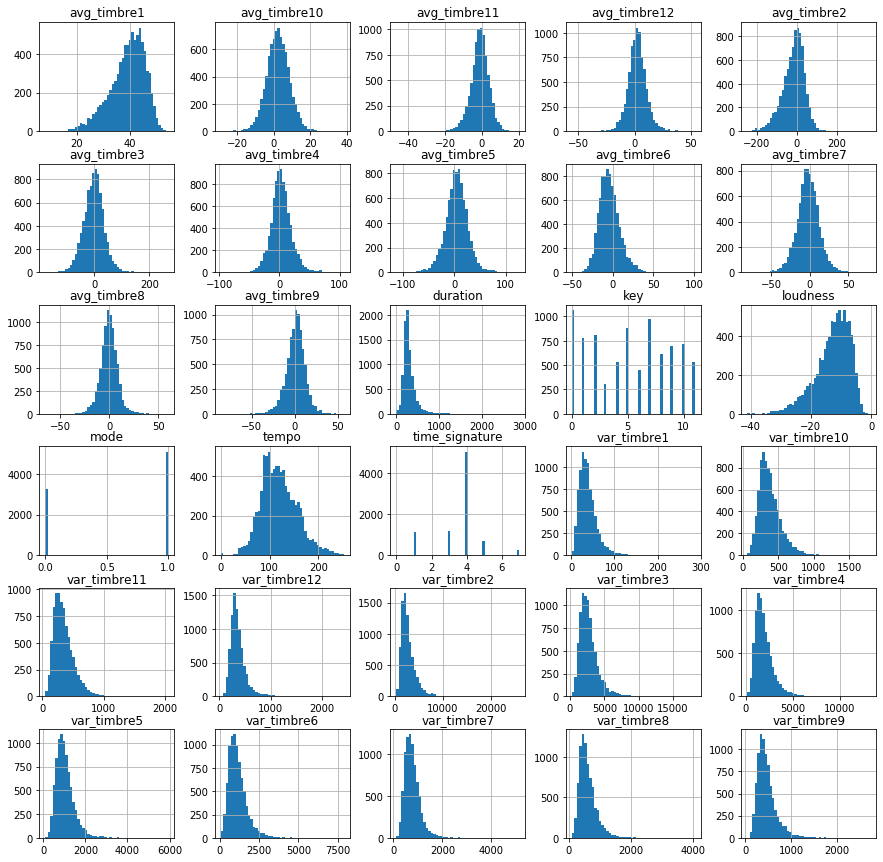

In [3]:
dataset = dataset.drop(columns = ["track_id", "artist_name", "title"])
features = dataset.columns.tolist()
dataset = dataset[(dataset["%genre"] == "jazz and blues") | (dataset["%genre"] == "soul and reggae")]
figure = dataset.hist(figsize=(15,15), bins = 50)

In [4]:
y = dataset["%genre"].values
X = dataset.values[:,1:]
X = X.astype(float)

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
lblEncoder = LabelEncoder()

y = lblEncoder.fit(np.unique(y)).transform(y)
##Se estandarizan los datos provenientes del archivo
normalized_X = scaler.fit(X).transform(X)

In [6]:
##Se agrega un vector de unos a los datos
data_rows = normalized_X.shape[0]
ones_vector =  np.ones([data_rows,1])
X_ones = np.concatenate((ones_vector , normalized_X), 1)

condition_number_1 = np.linalg.cond(np.matmul(X.T,X))
condition_number_2 = np.linalg.cond(np.matmul(X_ones.T,X_ones))

print("Número de condición datos sin preprocesar: %d" % (condition_number_1))
print("Número de condición datos preprocesados: %d" % (condition_number_2))

Número de condición datos sin preprocesar: 120283529
Número de condición datos preprocesados: 576


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ones, y, test_size = 0.2, random_state = 7861) 

In [8]:
a,b = np.unique(y_train, return_counts=True)
clase_0 = lblEncoder.inverse_transform([a[0]])[0]
clase_1 = lblEncoder.inverse_transform([a[1]])[0]
print("Elementos de entranamiento para la clase %s: %d" % (clase_0, b[0]))
print("Elementos de entranamiento para la clase %s: %d" % (clase_1, b[1]))

Elementos de entranamiento para la clase jazz and blues: 3455
Elementos de entranamiento para la clase soul and reggae: 3225


In [9]:
def sigmoid(X, w):
    z = np.matmul(X,w)
    y = 1/(1 + np.exp(-z))
    return y

In [10]:
def calculate_gradient(X, y, w):
    
    y_hat = sigmoid(X,w)
    error = y - y_hat  
    gradiente = np.matmul(error, X)
    
    return gradiente

In [11]:
def splitBatches(X, y, batch_size):
    ## Se obtiene el número total de datos
    m = X.shape[0]
    
    ##Se calcula la cantidad total de lotes
    batches = math.ceil(m/batch_size)
    
    ##Se mezclan aleatoriamente los datos
    np.random.seed(None)
    data = np.c_[X,y]
    np.random.shuffle(data)

    X_batches = []
    y_batches = []
    
    for i in range(batches):
        
        ##Se toman subconjuntos de datos con el tamaño especificado 
        X_batch = data[0:batch_size,:-1]
        X_batches.append(X_batch)
                
        y_batch = data[0:batch_size,-1]
        y_batches.append(y_batch)
        
        data = data[batch_size:,:]
        
    return X_batches, y_batches

In [15]:
def model_train(X, y, batch_size = 1, epocs = 5, learning_rate = 0.0001, tol = 1e-4):
    
    ##Se define el número de parámetros a entrenar
    n = X.shape[1]
    
    ##Se inicializan los parámetros a entrenar
    np.random.seed(7861)
    w_0 = np.random.rand(n)
    
    ##Se inicializa el error en un valor arbitrario
    actual_error = 2    
    
    for epoc in range(epocs):
        
        ##Se dividen los datos en lotes al inicio de cada época
        ##se realiza este procedimiento antes de cada época para 
        ##garantizar que los datos estén barajados de forma distinta
        ##en cada recorrido
        X_batches, y_batches = splitBatches(X, y, batch_size)
        
        for X_batch, y_batch in zip(X_batches, y_batches):
            
            ##Para cada lote, se realiza el cálculo del gradiente y
            ##la actualización de los pesos
            w = calculate_gradient(X_batch, y_batch, w_0)                  
            w_0 = w_0 + learning_rate * w
        
        ##Se calcula el error al final de cada recorrido por los datos
        previous_error = actual_error
        actual_error = cross_entropy(X, y, w_0)
        
        ##Se imprime el valor del error cada 100 épocas
        if (epoc % 100 == 0):     
            print("Epoc %d error: %.4f" % (epoc,actual_error))
            
        ##Se verifica que el cambio del error no sea menor a la toleracia
        ##cada 20 épocas
        if (epoc % 20 == 0 and np.abs(previous_error - actual_error) < tol):
            break
         
    ##Se reporta el error del modelo completamente entrenado
    print("Model error : %.4f" % (actual_error))
    return w_0

In [16]:
def cross_entropy(X, y, w):
    y_hat = sigmoid(X, w)
    error_vector = np.multiply(y, np.log(y_hat)) + np.multiply(1-y, np.log(1-y_hat))
    error = np.sum(error_vector)
    return error

In [20]:
W = model_train(X_train, y_train, batch_size = 100, learning_rate=0.0003, epocs = 2000, tol = 1e-6)

Epoc 0 error: -5224.2614
Epoc 100 error: -2445.7367
Epoc 200 error: -2442.9533
Epoc 300 error: -2441.5211
Epoc 400 error: -2440.6368
Epoc 500 error: -2440.0066
Epoc 600 error: -2439.6219
Epoc 700 error: -2439.4547
Epoc 800 error: -2439.3261
Epoc 900 error: -2438.9944
Epoc 1000 error: -2438.9143
Epoc 1100 error: -2438.9895
Epoc 1200 error: -2438.9349
Epoc 1300 error: -2438.7857
Epoc 1400 error: -2438.7860
Epoc 1500 error: -2438.7743
Epoc 1600 error: -2438.7393
Epoc 1700 error: -2438.9808
Epoc 1800 error: -2438.9224
Epoc 1900 error: -2439.0142
Model error : -2438.7325


In [51]:
from sklearn.linear_model import LogisticRegression
logRegression = LogisticRegression().fit(X_train[:,1:], y_train)

y_hat_sk = logRegression.predict(X_test[:,1:])
y_hat_GE = np.round(sigmoid(X_test, W))

f1_score_list = [f1_score(y_test, y_hat_sk),
                f1_score(y_test, y_hat_GE)]
precision_list = [precision_score(y_test, y_hat_sk),
                 precision_score(y_test, y_hat_GE)]
recall_list = [recall_score(y_test, y_hat_sk),
              recall_score(y_test, y_hat_GE)]

prob_sk = logRegression.predict_proba(X_test[:,1:])
prob_GE = sigmoid(X_test, W)

log_loss_list = [log_loss(y_test, prob_sk),
                log_loss(y_test, prob_GE)]

model_results = pd.DataFrame({
    "Porcentaje de datos" : ["Librería", "Gradiente estocástico"],    
    "Precisión" : precision_list,
    "Recall" : recall_list,
    "F1" : f1_score_list,
    "Log loss" : log_loss_list   
})

model_results

,Porcentaje de datos,Precisión,Recall,F1,Log loss
0,Librería,0.818182,0.830594,0.824341,0.390670
1,Gradiente estocástico,0.818182,0.830594,0.824341,0.390778


In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, log_loss
confusion_matrix(y_test, y_hat_GE)

array([[733, 146],
       [134, 657]], dtype=int64)

In [38]:
confusion_matrix(y_test, y_hat_sk)

array([[733, 146],
       [134, 657]], dtype=int64)

In [59]:
logRegression.coef_

array([[ 1.17319665,  0.00523208,  0.02554028,  0.01061036, -0.06035642,
        -0.64780003, -0.24082088,  0.64916219, -0.37545081,  0.35944598,
         0.177281  ,  0.54670164,  0.2345582 , -0.081816  ,  0.31419726,
        -0.11613311, -0.25294045, -0.13007418, -0.10219778, -0.7505917 ,
        -0.4674491 ,  0.19360642,  0.79454422, -0.45273506,  0.31263954,
         0.50572536,  0.03808219, -0.06793983,  0.25678458, -0.38452919]])

In [60]:
W[1:]

array([ 1.2515245 ,  0.00619962,  0.02393391,  0.00998879, -0.0592941 ,
       -0.65131659, -0.32083338,  0.65125535, -0.37392193,  0.36073999,
        0.17666994,  0.55220708,  0.23492944, -0.08140874,  0.31601902,
       -0.11794309, -0.25433855, -0.12959976, -0.1120375 , -0.75493996,
       -0.46980526,  0.18967339,  0.79796565, -0.46518466,  0.31271511,
        0.51032753,  0.03784924, -0.06902892,  0.25937408, -0.38620916])